In [1]:
import numpy as np
import itertools
import json

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration, _sigmoid_calibration
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score, generate_corruptions_for_eval
from sklearn.metrics import brier_score_loss, log_loss, accuracy_score
from scipy.special import expit

from ampligraph.datasets import load_yago39k
from ampligraph.latent_features.models import TransE, ComplEx, DistMult

In [2]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [3]:
X = load_yago39k()

In [4]:
X_valid_pos = X['valid'][X['valid_labels']]
X_valid_neg = X['valid'][~X['valid_labels']]

X_test_pos = X['test'][X['test_labels']]
X_test_neg = X['test'][~X['test_labels']]

In [5]:
import types
from functools import partial
import tensorflow as tf
from sklearn.utils import check_random_state
from tqdm import tqdm
from ampligraph.datasets import AmpligraphDatasetAdapter, NumpyDatasetAdapter
from ampligraph.evaluation import generate_corruptions_for_fit, to_idx, generate_corruptions_for_eval, \
    hits_at_n_score, mrr_score


def generate_corruptions(self, X_pos, batches_count, epochs):
    try:
        tf.reset_default_graph()
        self.rnd = check_random_state(self.seed)
        tf.random.set_random_seed(self.seed)

        self._load_model_from_trained_params()

        dataset_handle = NumpyDatasetAdapter()
        dataset_handle.use_mappings(self.rel_to_idx, self.ent_to_idx)

        dataset_handle.set_data(X_pos, "pos")

        gen_fn = partial(dataset_handle.get_next_batch, batches_count=batches_count, dataset_type="pos")
        dataset = tf.data.Dataset.from_generator(gen_fn,
                                                 output_types=tf.int32,
                                                 output_shapes=(None, 3))
        dataset = dataset.repeat().prefetch(1)
        dataset_iter = tf.data.make_one_shot_iterator(dataset)

        x_pos_tf = dataset_iter.get_next()

        e_s, e_p, e_o = self._lookup_embeddings(x_pos_tf)
        scores_pos = self._fn(e_s, e_p, e_o)

        x_neg_tf = generate_corruptions_for_fit(x_pos_tf,
                                                entities_list=None,
                                                eta=1,
                                                corrupt_side='s+o',
                                                entities_size=0,
                                                rnd=self.seed)

        e_s_neg, e_p_neg, e_o_neg = self._lookup_embeddings(x_neg_tf)
        scores = self._fn(e_s_neg, e_p_neg, e_o_neg)

        epoch_iterator_with_progress = tqdm(range(1, epochs + 1), disable=(not self.verbose), unit='epoch')

        scores_list = []
        with tf.Session(config=self.tf_config) as sess:
            sess.run(tf.global_variables_initializer())
            for _ in epoch_iterator_with_progress:
                losses = []
                for batch in range(batches_count):
                    scores_list.append(sess.run(scores))

        dataset_handle.cleanup()
        return np.concatenate(scores_list)
    
    except Exception as e:
        dataset_handle.cleanup()
        raise e

In [6]:
def pos_iso(cal_model, pos_scores, neg_scores, positive_base_rate):
    weigths_pos = len(neg_scores) / len(pos_scores)
    weights_neg = (1.0 - positive_base_rate) / positive_base_rate
    weights = np.concatenate((np.full(pos_scores.shape, weigths_pos),
                              np.full(neg_scores.shape, weights_neg))).astype(float)
    target =  np.concatenate((np.ones(pos_scores.shape), np.zeros(neg_scores.shape))).astype(float)
    x = np.concatenate((pos_scores, neg_scores)).astype(float)
    
    cal_model.fit(x, target, sample_weight=weights)
    return cal_model

In [7]:
results = []

for eta in [1, 5, 10, 20, 50, 100]:
    model = TransE(batches_count=64, seed=0, epochs=500, k=100, eta=eta,
                   optimizer='adam', optimizer_params={'lr':0.0001},
                   loss='self_adversarial', verbose=False)

    model.fit(X['train'])
    
    scores = model.predict(X['test'])

    model.calibrate(X_valid_pos, batches_count=10, epochs=1000, positive_base_rate=0.5)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X['test'])

    model.calibrate(X_valid_pos, X_valid_neg)
    print("pos neg", model.calibration_parameters)
    probas2 = model.predict_proba(X['test'])
    
    val_scores = model.predict(X['valid'])
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(np.squeeze(val_scores).astype(float), (X['valid_labels']).astype(float))
    probas3 = ir.predict(np.squeeze(scores).astype(float))
    
    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X_valid_pos, batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X_valid_pos))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=0.5)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=0.5)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))
    
    val_neg_scores = np.squeeze(model.predict(X_valid_neg))
    sc_pos_neg = pos_iso(_SigmoidCalibration(), val_pos_scores, val_neg_scores, positive_base_rate=0.5)
    print("pos neg sc", sc_pos_neg.a_, sc_pos_neg.b_)
    probas6 = sc_pos_neg.predict(np.squeeze(scores).astype(float))
    
    thresholds = {r: np.median(np.sort(val_scores[X['valid'][:, 1] == r])) for r in np.unique(X['valid'][:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(X['test'][:, 1])
    per_relation_acc = accuracy_score(X['test_labels'], scores > thresholds_test)

    acc_uncalib = accuracy_score(X['test_labels'], expit(scores) > 0.5)
    
    acc1 = accuracy_score(X['test_labels'], probas1 > 0.5)
    acc2 = accuracy_score(X['test_labels'], probas2 > 0.5)
    acc3 = accuracy_score(X['test_labels'], probas3 > 0.5)
    acc4 = accuracy_score(X['test_labels'], probas4 > 0.5)
    acc5 = accuracy_score(X['test_labels'], probas5 > 0.5)
    acc6 = accuracy_score(X['test_labels'], probas6 > 0.5)
    
    filter_triples = np.concatenate((X['train'], X_valid_pos, X_test_pos))
    ranks = evaluate_performance(X_test_pos, 
                                 model=model, 
                                 filter_triples=filter_triples,
                                 use_default_protocol=True, 
                                 verbose=False)

    results.append({
        'eta': eta,
        'brier_score_scores': brier_score_loss(X['test_labels'], expit(scores)),
        'log_loss_scores': log_loss(X['test_labels'], expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X['test_labels'], probas1),
        'log_loss_probas_pos': log_loss(X['test_labels'], probas1, eps=1e-7),
        'brier_score_probas_pos_neg': brier_score_loss(X['test_labels'], probas2),
        'log_loss_probas_pos_neg': log_loss(X['test_labels'], probas2, eps=1e-7),
        'brier_score_probas_pos_neg_iso': brier_score_loss(X['test_labels'], probas3),
        'log_loss_probas_pos_neg_iso': log_loss(X['test_labels'], probas3, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X['test_labels'], probas4),
        'log_loss_probas_pos_iso': log_loss(X['test_labels'], probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X['test_labels'], probas5),
        'log_loss_probas_pos_sc': log_loss(X['test_labels'], probas5, eps=1e-7),
        'brier_score_probas_pos_neg_sc': brier_score_loss(X['test_labels'], probas6),
        'log_loss_probas_pos_neg_sc': log_loss(X['test_labels'], probas6, eps=1e-7),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks),
        'accuracy_per_relation': per_relation_acc,
        'accuracy_uncalib': acc_uncalib,
        'accuracy_pos': acc1,
        'accuracy_pos_neg': acc2,
        'accuracy_pos_neg_iso': acc3,
        'accuracy_pos_iso': acc4,
        'accuracy_pos_sc': acc5,
        'accuracy_pos_neg_sc': acc6
    })
        
    print(json.dumps(results[-1], indent=2))

WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:429: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
WARNING - From /home/ptabacof/.

pos [-2.0423286, -7.474715]
pos neg [-1.9419165, -5.8799095]
pos sc -2.4212903741914884 -8.586640689960564
pos neg sc -1.943533593467525 -5.893041738678491
{
  "eta": 100,
  "brier_score_scores": 0.3692129535002751,
  "log_loss_scores": 1.0831319111087565,
  "brier_score_probas_pos": 0.11261500106943649,
  "log_loss_probas_pos": 0.39264592809967513,
  "brier_score_probas_pos_neg": 0.09444585864146834,
  "log_loss_probas_pos_neg": 0.3164940177411954,
  "brier_score_probas_pos_neg_iso": 0.09229144459833176,
  "log_loss_probas_pos_neg_iso": 0.3073779363946424,
  "brier_score_probas_pos_iso": 0.10933220054302384,
  "log_loss_probas_pos_iso": 0.3749523931479629,
  "brier_score_probas_pos_sc": 0.10612424629548223,
  "log_loss_probas_pos_sc": 0.3852205391333693,
  "brier_score_probas_pos_neg_sc": 0.09440793416525235,
  "log_loss_probas_pos_neg_sc": 0.31649749839451324,
  "metrics_mrr": 0.17647500412233416,
  "metrics_hits@10": 0.33259531266875475,
  "metrics_mr": 240.69710551895454,
  "accura

In [ ]:
eta_results = results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
df=pd.DataFrame(eta_results)
df.columns

Index(['accuracy_per_relation', 'accuracy_pos', 'accuracy_pos_iso',
       'accuracy_pos_neg', 'accuracy_pos_neg_iso', 'accuracy_pos_neg_sc',
       'accuracy_pos_sc', 'accuracy_uncalib', 'brier_score_probas_pos',
       'brier_score_probas_pos_iso', 'brier_score_probas_pos_neg',
       'brier_score_probas_pos_neg_iso', 'brier_score_probas_pos_neg_sc',
       'brier_score_probas_pos_sc', 'brier_score_scores', 'eta',
       'log_loss_probas_pos', 'log_loss_probas_pos_iso',
       'log_loss_probas_pos_neg', 'log_loss_probas_pos_neg_iso',
       'log_loss_probas_pos_neg_sc', 'log_loss_probas_pos_sc',
       'log_loss_scores', 'metrics_hits@10', 'metrics_mr', 'metrics_mrr'],
      dtype='object')

Text(0.5, 1.0, 'YAGO39K')

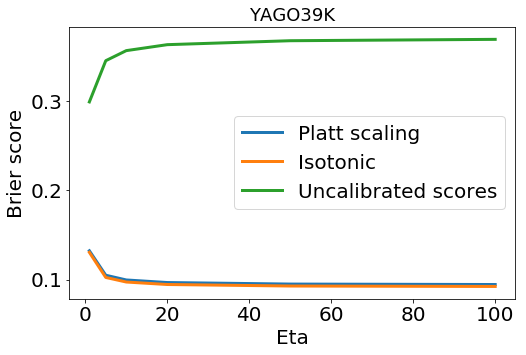

In [26]:
plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size': 20, 'axes.titlesize': 18})
plt.plot(df.eta, df.brier_score_probas_pos_neg, lw=3, label="Platt scaling")
plt.plot(df.eta, df.brier_score_probas_pos_neg_iso, lw=3, label="Isotonic")
plt.plot(df.eta, df.brier_score_scores, lw=3, label="Uncalibrated scores")
plt.xlabel("Eta")
plt.ylabel("Brier score")
plt.legend()
plt.title("YAGO39K")

In [9]:
results = []

for k in [10, 25, 50, 100, 200, 500]:
    model = TransE(batches_count=64, seed=0, epochs=500, k=k, eta=20,
                   optimizer='adam', optimizer_params={'lr':0.0001},
                   loss='self_adversarial', verbose=False)

    model.fit(X['train'])
    
    scores = model.predict(X['test'])

    model.calibrate(X_valid_pos, batches_count=10, epochs=1000, positive_base_rate=0.5)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X['test'])

    model.calibrate(X_valid_pos, X_valid_neg)
    print("pos neg", model.calibration_parameters)
    probas2 = model.predict_proba(X['test'])
    
    val_scores = model.predict(X['valid'])
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(np.squeeze(val_scores).astype(float), (X['valid_labels']).astype(float))
    probas3 = ir.predict(np.squeeze(scores).astype(float))
    
    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X_valid_pos, batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X_valid_pos))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=0.5)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=0.5)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))
    
    val_neg_scores = np.squeeze(model.predict(X_valid_neg))
    sc_pos_neg = pos_iso(_SigmoidCalibration(), val_pos_scores, val_neg_scores, positive_base_rate=0.5)
    print("pos neg sc", sc_pos_neg.a_, sc_pos_neg.b_)
    probas6 = sc_pos_neg.predict(np.squeeze(scores).astype(float))
    
    thresholds = {r: np.median(np.sort(val_scores[X['valid'][:, 1] == r])) for r in np.unique(X['valid'][:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(X['test'][:, 1])
    per_relation_acc = accuracy_score(X['test_labels'], scores > thresholds_test)

    acc_uncalib = accuracy_score(X['test_labels'], expit(scores) > 0.5)
    
    acc1 = accuracy_score(X['test_labels'], probas1 > 0.5)
    acc2 = accuracy_score(X['test_labels'], probas2 > 0.5)
    acc3 = accuracy_score(X['test_labels'], probas3 > 0.5)
    acc4 = accuracy_score(X['test_labels'], probas4 > 0.5)
    acc5 = accuracy_score(X['test_labels'], probas5 > 0.5)
    acc6 = accuracy_score(X['test_labels'], probas6 > 0.5)
    
    filter_triples = np.concatenate((X['train'], X_valid_pos, X_test_pos))
    ranks = evaluate_performance(X_test_pos, 
                                 model=model, 
                                 filter_triples=filter_triples,
                                 use_default_protocol=True, 
                                 verbose=False)

    results.append({
        'k': k,
        'brier_score_scores': brier_score_loss(X['test_labels'], expit(scores)),
        'log_loss_scores': log_loss(X['test_labels'], expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X['test_labels'], probas1),
        'log_loss_probas_pos': log_loss(X['test_labels'], probas1, eps=1e-7),
        'brier_score_probas_pos_neg': brier_score_loss(X['test_labels'], probas2),
        'log_loss_probas_pos_neg': log_loss(X['test_labels'], probas2, eps=1e-7),
        'brier_score_probas_pos_neg_iso': brier_score_loss(X['test_labels'], probas3),
        'log_loss_probas_pos_neg_iso': log_loss(X['test_labels'], probas3, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X['test_labels'], probas4),
        'log_loss_probas_pos_iso': log_loss(X['test_labels'], probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X['test_labels'], probas5),
        'log_loss_probas_pos_sc': log_loss(X['test_labels'], probas5, eps=1e-7),
        'brier_score_probas_pos_neg_sc': brier_score_loss(X['test_labels'], probas6),
        'log_loss_probas_pos_neg_sc': log_loss(X['test_labels'], probas6, eps=1e-7),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks),
        'accuracy_per_relation': per_relation_acc,
        'accuracy_uncalib': acc_uncalib,
        'accuracy_pos': acc1,
        'accuracy_pos_neg': acc2,
        'accuracy_pos_neg_iso': acc3,
        'accuracy_pos_iso': acc4,
        'accuracy_pos_sc': acc5,
        'accuracy_pos_neg_sc': acc6
    })
        
    print(json.dumps(results[-1], indent=2))

pos [-2.226997, -7.105285]
pos neg [-1.6107731, -4.131689]
pos sc -2.2173498127515012 -6.874475942617148
pos neg sc -1.6105140915906808 -4.139739587338658
{
  "k": 10,
  "brier_score_scores": 0.3881051005166901,
  "log_loss_scores": 1.1478125075549037,
  "brier_score_probas_pos": 0.21072499649607418,
  "log_loss_probas_pos": 0.6709544756663437,
  "brier_score_probas_pos_neg": 0.16788855783330797,
  "log_loss_probas_pos_neg": 0.5181600885349826,
  "brier_score_probas_pos_neg_iso": 0.16559730068885614,
  "log_loss_probas_pos_neg_iso": 0.5063889100419912,
  "brier_score_probas_pos_iso": 0.19920779143816406,
  "log_loss_probas_pos_iso": 0.6340553715461014,
  "brier_score_probas_pos_sc": 0.20036559864274517,
  "log_loss_probas_pos_sc": 0.6347199888967251,
  "brier_score_probas_pos_neg_sc": 0.16789471173312287,
  "log_loss_probas_pos_neg_sc": 0.5181666241185376,
  "metrics_mrr": 0.0751877423776671,
  "metrics_hits@10": 0.1382438708283832,
  "metrics_mr": 1031.6820390970947,
  "accuracy_per_r

In [10]:
k_results = results

In [27]:
df=pd.DataFrame(k_results)
df.columns

Index(['accuracy_per_relation', 'accuracy_pos', 'accuracy_pos_iso',
       'accuracy_pos_neg', 'accuracy_pos_neg_iso', 'accuracy_pos_neg_sc',
       'accuracy_pos_sc', 'accuracy_uncalib', 'brier_score_probas_pos',
       'brier_score_probas_pos_iso', 'brier_score_probas_pos_neg',
       'brier_score_probas_pos_neg_iso', 'brier_score_probas_pos_neg_sc',
       'brier_score_probas_pos_sc', 'brier_score_scores', 'k',
       'log_loss_probas_pos', 'log_loss_probas_pos_iso',
       'log_loss_probas_pos_neg', 'log_loss_probas_pos_neg_iso',
       'log_loss_probas_pos_neg_sc', 'log_loss_probas_pos_sc',
       'log_loss_scores', 'metrics_hits@10', 'metrics_mr', 'metrics_mrr'],
      dtype='object')

Text(0.5, 1.0, 'YAGO39K')

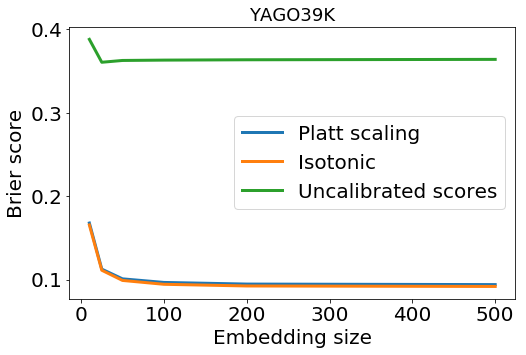

In [29]:
plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size': 20, 'axes.titlesize': 18})
plt.plot(df.k, df.brier_score_probas_pos_neg, lw=3, label="Platt scaling")
plt.plot(df.k, df.brier_score_probas_pos_neg_iso, lw=3, label="Isotonic")
plt.plot(df.k, df.brier_score_scores, lw=3, label="Uncalibrated scores")
plt.xlabel("Embedding size")
plt.ylabel("Brier score")
plt.legend()
plt.title("YAGO39K")